In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.utils.cross_validators import vbt_cv_sliding_constructor

In [331]:
pair = "btczec"
opens = get_csv_data(f"data/{pair}_hourly_opens.csv")
closes = get_csv_data(f"data/{pair}_hourly_closes.csv")
print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.20, train_size=0.80, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.20, train_size=0.80, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=5)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=5)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 26245
Test data length: 5249
Train fold length 4199


In [341]:
# BNB -> TRX 550 2.1 -2.5 1.9 1e-5 1.5 CUMMLOG 0.0006 <- works dur 360/38 trades per epoch
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# DBG DASH does not generalize on either log or cummlog model
# GRT INCH is a bust for both models
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?

PERIOD = 760
UPPER = 2.3
LOWER = -2.2
EXIT = 1.0
DELTA = 5e-4
VT = 1.28
BURNIN = 500
MODEL = "log"
SLIPPAGE = 0.0006
FREQ = "h"

In [342]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge="beta",
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

-0.02890215507303171


<AxesSubplot:xlabel='time'>

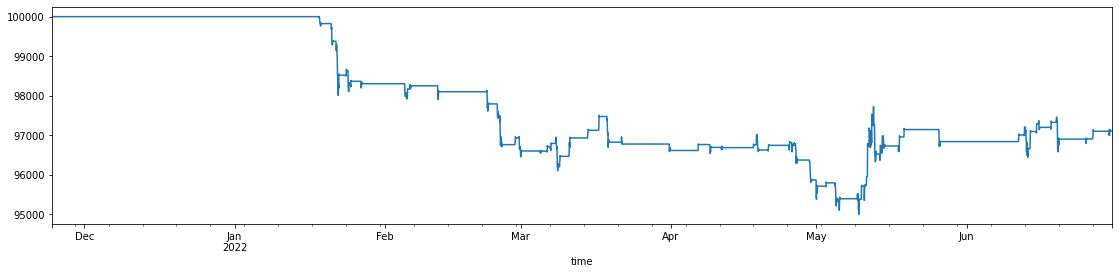

In [343]:
print(pf.total_return())

pf.value().plot(figsize=(19,4))

In [344]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].median() / np.abs(res.PnL[res.PnL < 0].median()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")

Total trades: 71
Executed trades: 142
Profit Ratio: 0.554
Net long-short win rate: 54.93%
Median trade profit: 18.33
Mean trade profit: -40.71
STD of trade profit: 333.35


<AxesSubplot:xlabel='Entry Timestamp'>

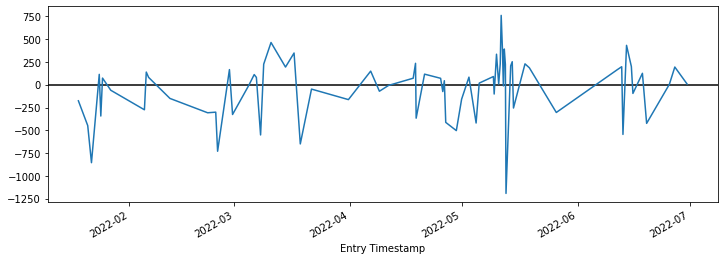

In [345]:
plt.axhline(0, color="black")
res.PnL.plot(figsize=(12,4))

In [346]:
pf.stats()

Start                               2021-11-24 07:00:00
End                                 2022-06-30 23:00:00
Period                                218 days 17:00:00
Start Value                                    100000.0
End Value                                  97109.784493
Total Return [%]                              -2.890216
Benchmark Return [%]                         -71.722041
Max Gross Exposure [%]                         7.525071
Total Fees Paid                             1552.884131
Max Drawdown [%]                               4.998624
Max Drawdown Duration                 163 days 14:00:00
Total Trades                                        142
Total Closed Trades                                 142
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  47.183099
Best Trade [%]                                11.305553
Worst Trade [%]                              -14